## **Implementation of stance detection problem using word2vec vectorization and baseline model**

---





In [25]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### To Download the necessary nltk libraries

In [26]:
import nltk
nltk.download('punkt')
nltk.download('words')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Importing Necessary libraries

In [0]:
import string
import re
import numpy as np
from nltk.corpus import words
from nltk.tokenize import word_tokenize
import pandas as pd
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.model_selection import cross_validate as cross_validation, ShuffleSplit, cross_val_score
import nltk
import warnings
warnings.filterwarnings("ignore")

### to break any combined word into its components for eg, hashtags

In [0]:
def simplify(word):
	dump = ''
	temp = []
	listOfWords = list(filter(None,re.split("([A-Z][^A-Z]*)",word)))
	if len(listOfWords) == len(word):
		return word.lower()
	for i in range(len(listOfWords)):
		listOfWords[i] = listOfWords[i].lower()
		if len(listOfWords[i]) == 1:
			dump = dump + listOfWords[i]
			if dump in words.words() and len(dump) > 2:
				temp.append(dump)
				dump = ''
		else:
			temp.append(listOfWords[i])
	return temp

### To Extract tokens from the given tweets

In [0]:
def createTokens(data):
  listOfTweets = []
  listOfStances = []
  tweetVector = []
  
  for ind, row in data.iterrows():
    
    # Create a sentence using target and the tweet. Word vector will be formed from this.
    example_sentence = str(row["Target"]) + " " + str(row["Tweet"])
    
    # Remove punctuation
    final_sentence = example_sentence.translate(string.punctuation)
    wordList = word_tokenize(final_sentence)
    wordList = [w.lower() for w in wordList]
    
    stop_words = set(stopwords.words('english'))
    wordList = [w for w in wordList if not w in stop_words] 
    
    finalList = []
    s = ' '.join([i for i in wordList if i.isalpha()])
    
    # create tokens from the string and stem them
    wordList = word_tokenize(s)
    
    for word in wordList:
      #to break any combined word into its components for eg, hashtags
      finalList += simplify(word)
    
    final_sentence = ' '.join(finalList)
    listOfTweets.append(word_tokenize(final_sentence))
  return listOfTweets

### For converting all the stances into numerical values in both training and test data

In [0]:
def labelStance(labelDict, data):
	for key, val in labelDict.items():
		data.loc[data["Stance"] == val, "Stance"] = int(key)
	return data

### For getting vector representation of words

In [0]:
def getWordVector(word, model):
  wordVector = model[word]
  return wordVector

### For extracting feature for tokanized tweet

In [0]:
def createVector(data, model):
  data = createTokens(data)
  tweetVector = []
  vector = np.zeros_like(model["abortion"])
  for tweet in data:
    for word in tweet:
      vector = vector + getWordVector(word,model)
    tweetVector.append(vector)
  tweetVector = np.asarray(tweetVector)
  return tweetVector

### To get stances

In [0]:
def getStances(data):
  stanceList = []
  for ind, row in data.iterrows():
    stanceList.append(row["Stance"])
  return np.asarray(stanceList)

### For processing the data and creating word2vec model form availabale vocabulary

In [33]:
classifiers = ['Support Vector Machine', 'Random Forest Classifier', 'Gradient Boosting Classifier', 'Logistic Regression', 'Neural Network', 'Gaussian NB', 'K Neighbors Classifier', 'Decision Tree Classifier']

trainTweets = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/stance-detection/training.txt', sep='\t',header=0,encoding='utf-8')
testTweets = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/stance-detection/test-gold.txt', sep='\t',header=0,encoding='utf-8')

labelDict = {0:"AGAINST", 1:"FAVOR", 2:"NONE"}
trainTweets = labelStance(labelDict, trainTweets)
testTweets = labelStance(labelDict, testTweets)   

print("Processing the dataset...........")
listOfTweets = pd.concat([trainTweets, testTweets], axis=0)
listOfTweets = createTokens(listOfTweets)
uniqTrainTargets = trainTweets.Target.unique()

print("Processing the word2vec model...........")
model = Word2Vec(listOfTweets, size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")

Processing the dataset...........
Processing the word2vec model...........


### Training and Testing tweet data with different baseline models

In [34]:
totalAcc = []
Targetacc = []
for classifier in classifiers:
  print("\nThe Machine Learning Model Used For Classification : " + classifier)
  temp = []
  total = 0
  for target in uniqTrainTargets:
    trainTweetVectors = createVector(trainTweets[trainTweets["Target"]==target], model)
    testTweetVectors = createVector(testTweets[testTweets["Target"]==target], model)
    trainStances = getStances(trainTweets[trainTweets["Target"]==target])
    testStances = getStances(testTweets[testTweets["Target"]==target])


#     print("\nProcessing the input for targrt " + str(target) + ".....")
#     print("Training Sample size : " + str(trainTweetVectors.shape[0]))
#     print("Testing Sample size : " + str(testTweetVectors.shape[0]))

    if classifier == 'Support Vector Machine':
      clf = SVC(kernel="rbf").fit(trainTweetVectors, trainStances)

    elif classifier == 'Random Forest Classifier':
      clf = RandomForestClassifier(n_estimators=90).fit(trainTweetVectors, trainStances)

    elif classifier == 'Gradient Boosting Classifier':
      clf = GradientBoostingClassifier().fit(trainTweetVectors, trainStances)

    elif classifier == 'Logistic Regression':
      clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(trainTweetVectors, trainStances)

    elif classifier == 'Neural Network':
      clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1).fit(trainTweetVectors, trainStances)

    elif classifier == 'Gaussian NB':
      clf = GaussianNB().fit(trainTweetVectors, trainStances)

    elif classifier == 'K Neighbors Classifier':
      clf = GaussianNB().fit(trainTweetVectors, trainStances)

    elif classifier == 'Decision Tree Classifier':
      clf = tree.DecisionTreeClassifier().fit(trainTweetVectors, trainStances)

    acc = clf.score(testTweetVectors, testStances)
#     print("Test Accuracy is "+ str(round(acc*100,2)) +"%")
    total = total + acc
    temp.append(acc)
    
  Targetacc.append(temp)
  total = total/len(uniqTrainTargets)
  print("\nTotal Test Accuracy is "+ str(round(total*100,2)) +"%")
  totalAcc.append(total)


The Machine Learning Model Used For Classification : Support Vector Machine

Total Test Accuracy is 54.17%

The Machine Learning Model Used For Classification : Random Forest Classifier

Total Test Accuracy is 44.11%

The Machine Learning Model Used For Classification : Gradient Boosting Classifier

Total Test Accuracy is 45.42%

The Machine Learning Model Used For Classification : Logistic Regression

Total Test Accuracy is 55.65%

The Machine Learning Model Used For Classification : Neural Network

Total Test Accuracy is 67.1%

The Machine Learning Model Used For Classification : Gaussian NB

Total Test Accuracy is 17.92%

The Machine Learning Model Used For Classification : K Neighbors Classifier

Total Test Accuracy is 17.92%

The Machine Learning Model Used For Classification : Decision Tree Classifier

Total Test Accuracy is 43.58%


###Comparison of Test Accuracy Individual Targets with different Baseline Models 

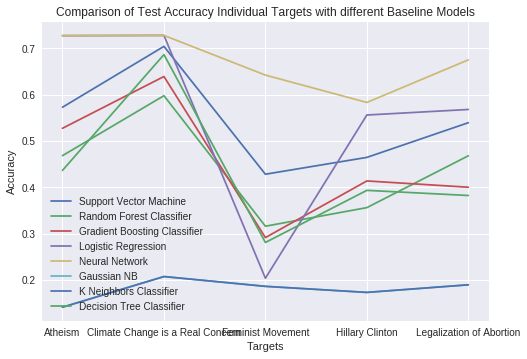

In [35]:
import matplotlib.pyplot as plt

x  = uniqTrainTargets
y  = Targetacc

for i in range(0,len(y)):
    plt.plot(x, y[i], label=classifiers[i])
plt.plot()

plt.xlabel("Targets")
plt.ylabel("Accuracy")
plt.title("Comparison of Test Accuracy Individual Targets with different Baseline Models")
plt.legend()
plt.show()

### Comparison of Total Test Accuracy of different Baseline Models

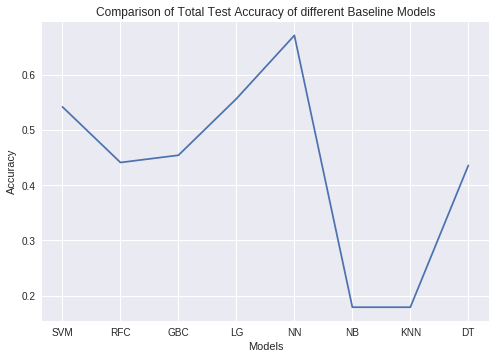

In [36]:
import matplotlib.pyplot as plt

x  = ['SVM', 'RFC', 'GBC', 'LG', 'NN', 'NB', 'KNN', 'DT']
y  = totalAcc

plt.plot(x, y)
plt.plot()

plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Comparison of Total Test Accuracy of different Baseline Models")
plt.show()

### Training and Testing with CNN


In [38]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import numpy as np


def Model1(X_train, X_test, y_train, y_test):
	model = Sequential()
	model.add(Conv2D(32, kernel_size=(3, 3),
	                 activation='relu',
	                 input_shape=(10,10,3)))
	model.add(Conv2D(64, (3, 3), activation='relu'))
	model.add(MaxPooling2D(pool_size=(2, 2)))
	model.add(Dropout(0.25))
	model.add(Flatten())
	model.add(Dense(128, activation='relu'))
	model.add(Dropout(0.5))
	model.add(Dense(num_classes, activation='softmax'))

	model.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=keras.optimizers.Adadelta(),
	              metrics=['accuracy'])

	model.fit(X_train, y_train,
	          batch_size=batch_size,
	          epochs=epochs,
	          verbose=1,
	          validation_data=(X_test, y_test))
	score = model.evaluate(X_test, y_test, verbose=0)
	# print('Test loss:', score[0])
	# print('Test accuracy:', score[1])
	return score[1]

def Model1(X_train, X_test, y_train, y_test):
	model = Sequential()
	model.add(Conv2D(32, kernel_size=(3, 3),
	                 activation='relu',
	                 input_shape=(10,10,3)))
	model.add(Conv2D(64, (3, 3), activation='relu'))
	model.add(MaxPooling2D(pool_size=(2, 2)))
	model.add(Dropout(0.25))
	model.add(Flatten())
	model.add(Dense(128, activation='relu'))
	model.add(Dropout(0.5))
	model.add(Dense(num_classes, activation='softmax'))

	model.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=keras.optimizers.Adadelta(),
	              metrics=['accuracy'])

	model.fit(X_train, y_train,
	          batch_size=batch_size,
	          epochs=epochs,
	          verbose=1,
	          validation_data=(X_test, y_test))
	score = model.evaluate(X_test, y_test, verbose=0)
	# print('Test loss:', score[0])
	# print('Test accuracy:', score[1])
	return score[1]


batch_size = 10
num_classes = 3
epochs = 12

# input image dimensions
img_rows, img_cols = 10, 10

from PIL import Image 

Tacc = 0
for target in uniqTrainTargets:
  X_train = createVector(trainTweets[trainTweets["Target"]==target], model)
  X_test = createVector(testTweets[testTweets["Target"]==target], model)
  y_train = getStances(trainTweets[trainTweets["Target"]==target])
  y_test = getStances(testTweets[testTweets["Target"]==target])
  mylist = []
  for item in X_train:
    img = Image.fromarray(item.reshape(10,10), 'RGB')
    img = np.asarray( img, dtype="int32" )
    mylist.append(img)
  X_train = np.array(mylist)
  
  mylist = []
  for item in X_test:
    img = Image.fromarray(item.reshape(10,10), 'RGB')
    img = np.asarray( img, dtype="int32" )
    mylist.append(img)
  X_test = np.array(mylist)

  X_train = X_train.reshape(X_train.shape[0],10,10,3)
  X_test = X_test.reshape(X_test.shape[0],10,10,3)

  # convert class vectors to binary class matrices
  y_train = keras.utils.to_categorical(y_train, num_classes)
  y_test = keras.utils.to_categorical(y_test, num_classes)

  acc = Model1(X_train, X_test, y_train, y_test)
  Tacc += acc
print("Total accuracy : "+ str( Tacc/5))

Train on 513 samples, validate on 220 samples
Epoch 1/12
513/513 [==============================] - 3s 7ms/step - loss: 6.7274 - acc: 0.5750 - val_loss: 4.3958 - val_acc: 0.7273
Epoch 2/12
513/513 [==============================] - 0s 751us/step - loss: 6.6579 - acc: 0.5848 - val_loss: 4.3958 - val_acc: 0.7273
Epoch 3/12
513/513 [==============================] - 0s 748us/step - loss: 6.5666 - acc: 0.5926 - val_loss: 4.3958 - val_acc: 0.7273
Epoch 4/12
513/513 [==============================] - 0s 770us/step - loss: 6.5678 - acc: 0.5926 - val_loss: 4.3958 - val_acc: 0.7273
Epoch 5/12
513/513 [==============================] - 0s 758us/step - loss: 6.5352 - acc: 0.5945 - val_loss: 4.3958 - val_acc: 0.7273
Epoch 6/12
513/513 [==============================] - 0s 759us/step - loss: 6.5860 - acc: 0.5887 - val_loss: 4.3958 - val_acc: 0.7273
Epoch 7/12
513/513 [==============================] - 0s 770us/step - loss: 6.5666 - acc: 0.5926 - val_loss: 4.3958 - val_acc: 0.7273
Epoch 8/12
513/513